In [20]:
import sys
# Add the seplmobot/ subirectory to the module search path, so that the modules in this directory are visible from the notebook.
sys.path.append('../selenobot/')

from utils import *
from extend import extend 

from dataset import Dataset, get_dataloader 
from embedders import AacEmbedder, LengthEmbedder
from classifiers import Classifier, SimpleClassifier
from utils import csv_size
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import fabapi

# Some specs for plotting.
TITLE_FONT_SIZE, LABEL_FONT_SIZE = 10, 10
FIGSIZE = (4, 3)
# Set all matplotlib global parameters.
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size':LABEL_FONT_SIZE})
plt.rc('xtick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('ytick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('axes',  **{'titlesize':TITLE_FONT_SIZE, 'labelsize':LABEL_FONT_SIZE})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

# Validation

In order to further validate the promising results of the PLM classifier on the testing data, we sought to interrogate a well-characterized microbial genome using the model. To this end, we chose to analyze the complete genome of *Escherichia coli* (strain K-12, substrain. MG1655, assembly ASM584v2). The RefSeq accession for this genome is GCF_000005845.2. 

For organizational purposes, all data used for model validation is placed into a subdirectory within the data directory. If you want to run this code, be sure to modify the `DATA_DIR` variable below to specify where the data will be stored on your machine.


In [4]:
DATA_DIR = '/home/prichter/Documents/data/selenobot/validation'
GENOME_ID = 'GCF_000005845.2' # The accession of E. coli strain K-12 substrain MG1655
ASSEMBLY = 'ASM584v2' # The specific genome assembly.

## Downloading genome data

Genome data can be downloaded using the NCBI’s REST API. The code below downloads a ZIP archive containing the genomic.gff, protein.faa, and genome.fna files.


In [ ]:
# # Download and unzip the genome data from NCBI. 
# ! curl 'https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/{GENOME_ID}/download?include_annotation_type=GENOME_FASTA,PROT_FASTA,GENOME_GFF' -o '{DATA_DIR}/ncbi_dataset.zip'
# ! unzip '{DATA_DIR}/ncbi_dataset.zip' -d '{DATA_DIR}'

In [12]:
def clean(path:str) -> NoReturn:
    '''Modify the format of downloaded FASTA files to standardize reading and writing FASTA files.'''
    fasta = ''
    with open(path, 'r') as f:
        lines = f.readlines()
    # In the FASTA files downloaded from NCBI, the only relevant information is right after the > character.
    # This is the GenBank protein accession, which will be called the 'id'.
    for line in lines:
        if '>' in line: # This symbol marks the beginning of a header file.
            id_ = re.search('>([^\s]+)', line).group(1)
            fasta += f'>id={id_}\n'
        else:
            fasta += line
    # This will overwrite the original file. 
    with open(path, 'w') as f:
        f.write(fasta)

In [13]:
clean(f'{DATA_DIR}/{GENOME_ID}/protein.faa')

### Truncating known selenoproteins

The E. coli genome assembly used contains three known selenoproteins: fdoG (RefSeq accession NP_418330.1), fdnG (RefSeq accession NP_415991.1) and fdhF (RefSeq accession NP_418503.1). The RefSeq accessions are found using the NCBI annotation browser for the particular E. coli genome assembly. Prior to generating the PLM embeddings, each of these sequences in the protein.faa file is truncated at the first selenocysteine residue. These sequences will act as sanity checks, ensuring that the PLM classifier is able to identify sequences known to be truncated selenoproteins. 

In [16]:
known_selenoproteins = ['NP_418330.1', 'NP_415991.1', 'NP_418503.1'] # The IDs of known selenoproteins in the E. coli genome. 

In [30]:
def truncate_selenoproteins(path:str, gene_ids:List[str]=None) -> NoReturn:
    '''Truncate the known selenoproteins stored in the input file, which are specified using the gene_ids
    parameter.'''
    # Load the selenoproteins into a pandas DataFrame. 
    df = dataframe_from_fasta(path)
    for row in df.itertuples(index=True):
        if getattr(row, 'id') in gene_ids:
            u_loc = row.seq.index('U')
            # setattr(row, 'seq', row.seq[:u_loc])
            row = row._replace(seq=row.seq[:u_loc])
            print(f"truncate_selenoproteins: Truncated {getattr(row, 'id')}.")
            df.loc[row.Index] = row[1:] # Save the edited row in the DataFrame.
    dataframe_to_fasta(df, path=path)

In [31]:
truncate_selenoproteins(f'{DATA_DIR}/protein.faa', gene_ids=known_selenoproteins)

truncate_selenoproteins: Truncated NP_415991.1.
truncate_selenoproteins: Truncated NP_418330.1.
truncate_selenoproteins: Truncated NP_418503.1.


## Predicting selenoproteins

### Generating PLM embeddings

Using the same procedure as was used to create embeddings for the UniProt sequences for training the classifier, embeddings are generated for all predicted genes in the model genome. The code for embedding sequence data is provided in the `embed.py` file in the `scripts` directory. The process for generating embeddings was computationally-intensive, and had to be run on an external computer cluster. The steps of the embedding algorithm, which is implemented by the `PlmEmbedder` class, described in the `setup.ipnyb` notebook. The embedded genome of *E. coli* is available on a Google Cloud repository, and can be downloaded using the code below.

In [ ]:
# Uncomment the line below to downloaded the embedded E. coli genome. 
# curl 'https://storage.googleapis.com/selenobot-data/{genome_id}/embeddings.csv' -o '{DATA_DIR}/embeddings.csv'

### Running the PLM classifier

The same workflow as described in the `training.ipynb` and `testing.ipynb` notebooks is used to predict selenoproteins in the model genome. First, the `proteins.faa` file, which contains the predicted amino acid sequences in the genome, is loaded into a pandas `DataFrame` and used to initialize a `Dataset` object. Then, the model’s predict method is called on the `Dataset`, generating a `TestReporter` object which stores model output. A threshold of `0.5` is applied to the model output, selecting positive classifications in which the model is over 50 percent confident. The IDs of the candidate selenoprotein sequences and the model confidence values are written to a `predictions.csv` file. 

In [7]:
model = Classifier(latent_dim=1024, hidden_dim=512) # Instantiate the PLM Classifier.
model.load_state_dict(torch.load(f'{DATA_DIR}../plm_model_weights.pth')) # Load pre-trained weights into the PLM classifier. 

<All keys matched successfully>

In [ ]:
embeddings_df = pd.read_csv(f'{DATA_DIR}/embeddings.csv', index_col=0) # Read the PLM embeddings into a pandas DataFrame. 
reporter = model.predict(Dataset(embeddings_df, embedder=None)) # Run the classifier on the PLM embeddings. 

predictions_df = embeddings_df[reporter.apply_threshold(threshold=0.5) == 1] # Select the entries in the embeddings DataFrame for which the meet the threshold.
predictions_df['confidence'] = reporter.outputs[reporter.apply_threshold(threshold=0.5) == 1] # Add the model confidences to the DataFrame. 
predictions_df[['id', 'confidence']].set_index('id').to_csv(f'{DATA_DIR}/predictions.csv') # Write the predictions DataFrame to a file, not including the embeddings.

In [ ]:
print('Number of predicted selenoproteins:', len(predictions_df))

## Extending flagged sequences

First, the data in the genomic.gff file (e.g.  the start and stop position of each sequence in the genome, as well as whether the gene is read from the forward or reverse strand) is merged with the DataFrame containing the predicted selenoproteins. This information is used to extend each amino acid sequence to the next stop codon using the following procedure.

1. **Read in the complete genome sequence from the genome.fna file.**
2. **The terminal location of the sequence is located in the genome, and incremented from right to left (reverse) or left to right (forward) until the next stop codon is encountered.** Valid stop codons are TAA, TAG and TGA, and their reversed equivalents.
3. **The new gene coordinates, the original stop codon, etc. are stored in the input DataFrame.** 
5. **Each extended nucleotide sequence is translated to a sequence of amino acids.** This is done using the `BioPython` `Seq` module. The translation utilities provided by `BioPython` do not support non-standard amino acids, so the selenocysteine residue (U) is added manually after the translation step. 

The extended sequences are written to a FASTA file called query.fasta, which is used during homology search with MMSeqs2. In addition to the extended sequences, this file contains the information about the gene coordinates (for the extended sequence), the codon predicted to encode for selenocysteine, and the size of the extension. 


In [14]:
predictions_df = pd.read_csv(f'{DATA_DIR}/predictions.csv') # Read in the model predictions. 
predictions_df = predictions_df.merge(dataframe_from_gff(f'{DATA_DIR}/genomic.gff'), on='id') # Add the information from the GFF file. 

As expected, the truncated known selenoproteins are detected by the classifier. These are excluded from further analysis (partly because it is not particularly interesting, and partly because the gene coordinates in the `genomic.gff` file were not modified, so the code for sequence extension will not work correctly). We also exclude ivbL, which is a known false positive (it is part of a dense, multi-gene operon), as well as sequences which are not registering valid start codons.

In [17]:
predictions_df = predictions_df[~predictions_df['id'].isin(known_selenoproteins)] # Remove known selenoproteins.
predictions_df = predictions_df[~predictions_df['id'].str.match('NP_418128.1')] # Remove ilvB.
predictions_df = predictions_df[~predictions_df['id'].isin(['QVL37563.1', 'QVL37671.1'])] # Genes have no valid start codon.

In [18]:
def load_genome(path:str) -> str:
    '''Load in the complete nucleotide sequence of the genome.
    
    :param path: A FASTA file from NCBI which contains a complete genome. 
    :return: A string of nucleotides. 
    '''
    with open(path, 'r') as f:
        lines = f.read().splitlines()[1:] # Skip the header line. 
        seq = ''.join(lines)
    return seq

In [21]:
predictions_df = extend(predictions_df, load_genome(f'{DATA_DIR}/genome.fna')) # Extend the predictions using the complete genome. 
dataframe_to_fasta(predictions_df, f'{DATA_DIR}/query.faa') # Write extended sequences to a FASTA file. 

In [48]:
print('Number of extended predicted selenoproteins:', len(predictions_df))

Number of extended predicted selenoproteins: 33


## Homology search against GTDB

The MMSeqs2 tool is used to search for sequences homologous to the extended candidate selenoproteins in the `query.faa` file. This search was performed on a remote computing cluster, and a full description of the procedure is provided in the Methodology document. The output of the homology search is a file where each row represents a single query-target match. The table is in the style of [BLAST output format 6](https://www.metagenomics.wiki/tools/blast/blastn-output-format-6). 

### Downloading sequences for MMSeqs2 hits

The output file produced by MMSeqs2 does not contain the amino acid sequences for the matching targets. These sequences are stored in a remote SQL database hosted by Caltech, and can be downloaded using the [Find-A-Bug Python API](https://github.com/pipparichter/find-a-bug-api). 

In [49]:
# Load in the MMSeqs results, dropping the two columns which are not populated by the program.
mmseqs_df = dataframe_from_m8(f'{DATA_DIR}/mmseqs_results.m8').drop(columns=['query_align_seq', 'target_align_seq'])

In [51]:
target_seqs = []
for target_id in mmseqs_df.target_id:
    seq = fabapi.get_sequences_with_gene_id(target_id).seq.item() # API returns a DataFrame, so we need to extract the sequence.
    target_seqs.append(seq)
mmseqs_df['target_seq'] = target_seqs # Add the target sequences to the MMSeqs2 results data. 

In [54]:
mmseqs_df.set_index('query_id').to_csv(f'{DATA_DIR}/mmseqs_results.csv') # Write the DataFrame to a file.

### Filtering MMSeqs2 hits

The sequences determined to be homologous to a query sequence by MMSeqs2 are filtered according to whether or not the homology region overlaps the predicted selenocysteine in the query sequence. Additionally, some of the query sequences which are false positives (specifically ivlB, which is an operon) were removed prior to further analysis. 

In [5]:
mmseqs_df = pd.read_csv(f'{DATA_DIR}/mmseqs_results.csv')

In [6]:
print('Number of MMSeqs hits before filtering:', len(mmseqs_df))

Number of MMSeqs hits before filtering: 29441


In [7]:
def check_hit_overlap(row):
    '''Check if a particular MMSeqs hit spans the stop codon in the query sequence.'''
    # We want the start of the hit to precede the U codon, and the end of the hit
    # to lie in the extended region. 
    u_pos = int(row.query_aa_length) - (int(row.query_nt_ext) // 3)
    return (u_pos > row.target_align_start) and (u_pos < row.target_align_stop)

In [8]:
mmseqs_df = mmseqs_df[mmseqs_df.apply(check_hit_overlap, axis=1)]

In [9]:
print('Number of hits after filtering by overlap:', len(mmseqs_df))

Number of hits after filtering by overlap: 27759


In [22]:
# Create a BLAST target file containing sequences in GTDB which passed the filtering step. 
dataframe_to_fasta(mmseqs_df[['target_seq', 'target_id']].rename(columns={'target_seq':'seq', 'target_id':'id'}), f'{DATA_DIR}/blast_target.faa')
# Create a BLAST query file containing predictions with MMSeqs2 hits that passed the filtering step..
dataframe_to_fasta(predictions_df[predictions_df['id'].isin(mmseqs_df.query_id)], f'{DATA_DIR}/blast_query.faa')

### Aligning homologs 

Pairwise sequence alignment is performed between each hit in GTDB and the remaining candidate selenoproteins. This secondary alignment provides more detailed about the homology match. This secondary alignment step provides information about each match, including the identity of the specific residue in the target sequence corresponding to the predicted selenocysteine in the query sequence. 

In [23]:
# Define a custom TSV output format for the BLAST alignment. See https://www.metagenomics.wiki/tools/blast/blastn-output-format-6.  
outfmt = '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qseq sseq'

In [64]:
# Modify this command so the path points towards your BLAST installation. 
! '/home/prichter/ncbi-blast-2.15.0+/bin/blastp' -subject '{DATA_DIR}/blast_target.faa' -query '{DATA_DIR}/blast_query.faa' -outfmt '{outfmt}' -out '{DATA_DIR}/blast_results.m8'

In [24]:
blast_df = dataframe_from_m8(f'{DATA_DIR}/blast_results.m8') # Load the results of BLAST pairwise alignment. 
blast_df = blast_df[blast_df.query_align_seq.str.contains('U')] # An additional filtering step to remove matches where the alignment region does not cover the selenocysteine.

# Rename some redundant columns. 
cols = ['percentage_identical', 'align_length', 'num_mismatches', 'num_gap_openings',  'query_align_start', 'query_align_stop', 'target_align_start', 'target_align_stop', 'e_value', 'bit_score', 'query_align_seq', 'target_align_seq']
mmseqs_df = mmseqs_df.rename(columns={col:f'mmseqs_{col}' for col in cols})
blast_df = blast_df.rename(columns={col:f'blast_{col}' for col in cols})

# Combine the MMSeqs and BLAST results into a single DataFrame. 
results_df = blast_df.merge(mmseqs_df, on=['query_gene_id', 'target_id', 'query_id'], how='left')

In [25]:
print('Final number of alignments:', len(results_df))

Final number of alignments: 26


## Downloading gene metadata

Other information, such as the KEGG annotations and the taxonomy of the target sequences, could prove informative for interpreting the homology search results. This metadata can be retrieved  using the Find-A-Bug API from a web server hosted by Caltech. 

In [ ]:
# Obtain the KO group for each target sequence. 
kos = []
for target_id in tqdm(results_df.target_id, desc='Retrieving KO groups for each target gene ID.'):
    df = fabapi.get_annotations_with_gene_id(target_id)
    # Sometimes there is more than one annotation for a particular gene. 
    ko = 'None' if len(df) == 0 else ','.join(list(df.ko.values)) 
    kos.append(ko)   
results_df['ko'] = kos # Add the KO groups to the results DataFrame. 

# Obtain the genome ID for each target sequence. 
target_genome_ids = []
for target_id in tqdm(results_df.target_id, desc='Retrieving genome ID for each target gene ID.'):
    df = fabapi.get_sequences_with_gene_id(target_id)
    genome_id = df.genome_id.item()
    target_genome_ids.append(genome_id) 
results_df['target_genome_id'] = target_genome_ids # Add the genome Ids to the results DataFrame.

# Get all fields with GTDB taxonomy information to pass into the query. 
dfs = []
for row in tqdm(list(results_df.itertuples())):
    df = fabapi.get_metadata_with_genome_id(row.target_genome_id, fields=['gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_family', 'gtdb_genus', 'gtdb_species', 'gtdb_domain'])
    df['id'] = row.target_id # Add the gene ID to the DataFrame for merging later on. 
    dfs.append(df)
df = pd.concat(dfs).rename(columns={col:f'target_{col}' for col in df.columns}) # Rename the columns so association with "target" gene is explicit.
# Add the taxonomy information to the results DataFrame. Some of the genes belong to the same genome, so need to merge based on both fields. 
results_df = results_df.merge(df, on=['target_genome_id', 'target_id'], how='left')

In [ ]:
results_df.to_csv(f'{DATA_DIR}/results.csv')

## Analyzing results

In [27]:
results_df = pd.read_csv(f'{DATA_DIR}/results.csv') # Read in the final homology search results.

In [28]:
# Determine the residues in the target sequences which match up with the predicted U.
residues = {i:[] for i in set(results_df.query_id.values)} 
for row in results_df.itertuples():
    u_pos = row.blast_query_align_seq.index('U')
    residues[row.query_id].append(row.blast_target_align_seq[u_pos])
    
print(residues)

{'YP_009518810.1': ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R'], 'YP_010051181.1': ['S', 'N', 'S']}


In [107]:
# results_df.set_index('query_id').to_csv(f'{DATA_DIR}/results.csv')

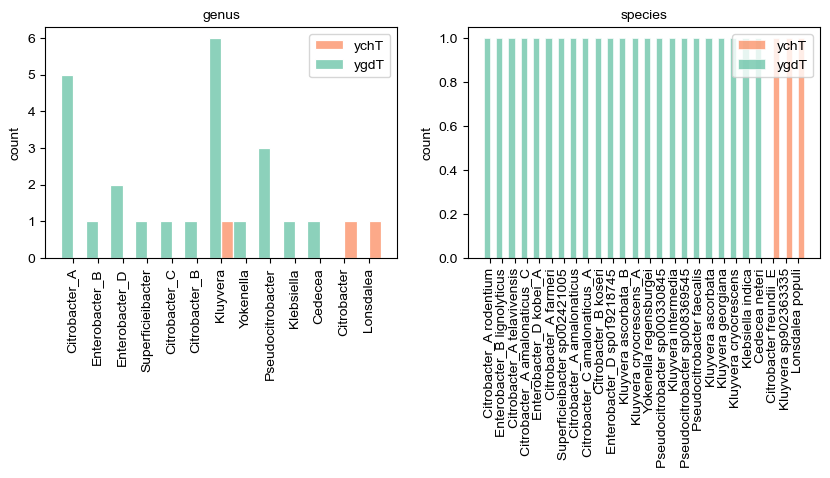

In [35]:
# taxonomy_levels = ['domain', 'class', 'phylum', 'order', 'family', 'genus']
taxonomy_levels = ['genus', 'species']
fig, axs = plt.subplots(1, len(taxonomy_levels), figsize=(5* len(taxonomy_levels), 3))

for level, ax in zip(taxonomy_levels, list(axs)):
    data = results_df[['query_gene_id', f'target_gtdb_{level}']]
    sns.histplot(data=data, x=f'target_gtdb_{level}', hue='query_gene_id', ax=ax, multiple='dodge', ec='white')
    ax.set_title(level)
    ax.legend(['ychT', 'ygdT'])
    ax.set_xlabel('')
    ax.set_ylabel('count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

plt.xticks(rotation='vertical')
plt.show()

### Alphafold

The `result_model_*.pkl` files in each output directory contains a nested dictionary of the various NumPy arrays directly produced by the model, as well as several auxiliary outputs. Of particular relevance to this analysis, they contain per-residue pLDDT scores in the `plddt` field. The scores are in the form of a NumPy array of shape `[N_res]` with the range of possible values from `0` to `100`, where `100` means most confident. This can serve to identify sequence regions predicted with high confidence or as an overall per-target confidence score when averaged across residues.

In [30]:
ALPHAFOLD_DATA_DIR = f'{DATA_DIR}/alphafold'

In [31]:
# Highest-ranking models can be obtained from the ranking_debug.json folder in the output directory. 

ygdt_1_model = 'model_4_multimer_v2_pred_2' # Score is 0.07132840454292307.
ygdt_0_model = 'model_1_multimer_v2_pred_3' # Score is 0.07062901407561006.
ycht_1_model = 'model_3_multimer_v2_pred_3' # Score is 0.15660095844585872.
ycht_0_model = 'model_3_multimer_v2_pred_2' # Score is 0.005277252731041432.

In [32]:
with open(f'{ALPHAFOLD_DATA_DIR}/ygdt_1/result_{ygdt_1_model}.pkl', 'rb') as f_1, open(f'{ALPHAFOLD_DATA_DIR}/ygdt_0/result_{ygdt_0_model}.pkl', 'rb') as f_0: 
    ygdt_1_model_info = pickle.load(f_1)
    ygdt_0_model_info = pickle.load(f_0)

with open(f'{ALPHAFOLD_DATA_DIR}/ycht_1/result_{ycht_1_model}.pkl', 'rb') as f_1, open(f'{ALPHAFOLD_DATA_DIR}/ycht_0/result_{ycht_0_model}.pkl', 'rb') as f_0: 
    ycht_1_model_info = pickle.load(f_1)
    ycht_0_model_info = pickle.load(f_0)

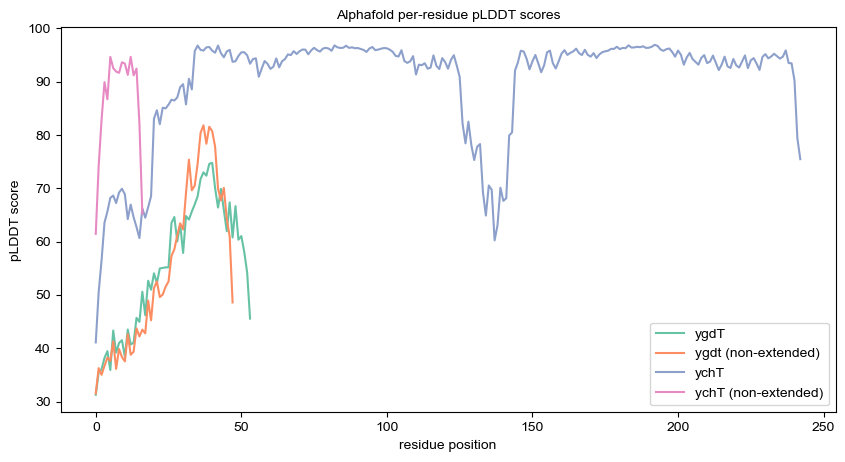

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 5))

ax.plot(np.arange(len(ygdt_1_model_info['plddt'])), ygdt_1_model_info['plddt'])
ax.plot(np.arange(len(ygdt_0_model_info['plddt'])), ygdt_0_model_info['plddt'])
ax.plot(np.arange(len(ycht_1_model_info['plddt'])), ycht_1_model_info['plddt'])
ax.plot(np.arange(len(ycht_0_model_info['plddt'])), ycht_0_model_info['plddt'])

ax.set_ylabel('pLDDT score')
ax.set_xlabel('residue position')
ax.legend(['ygdT', 'ygdt (non-extended)', 'ychT', 'ychT (non-extended)'])
ax.set_title('Alphafold per-residue pLDDT scores')
plt.show()

### Additional extension of ygdT

The first extension of ygdT sequence only added 6 amino acids to the sequence. It is possible (although not as common) that a sequence contains more than one selenocysteine residue. To see if this might be the case for ygdT, we can ask: 
1. Does the PLM classifier continue to classify the extended ygdT as truncated?
2. Does the new sequence have any homologs in GTDB?
3. How does the Alphafold structure prediction of the new sequence compare to the once-extended ygdT?

In [57]:
# Load in the version of ygdT extended to the first stop codon. This is contained in the query.faa file generated previously. 
ygdt_1 = dataframe_from_fasta(f'{DATA_DIR}/{GENOME_ID}/query.faa')
ygdt_1 = ygdt_1[ygdt_1.gene_id.str.match('ygdT')]
ygdt_1.head()

,seq,id,confidence,scaffold_id,feature,nt_start,nt_stop,reverse,frame,gene_id,nt_ext,aa_length,u_codon
15,MLSTESWDNCEKPPLLFPFTALTCDETPVFSGSVLNLVAHSVDKYG...,YP_009518810.1,0.8395561,RefSeq,CDS,2969311,2969476,True,0,ygdT,18,55,TGA


In [58]:
# Read in the E. coli genome, and extend the sequence to the next stop codon. 
genome = load_genome(f'{DATA_DIR}/{GENOME_ID}/genome.fna')

# Extend ygdT to the second stop codon, and write both versions to FASTA files for embedding. 
ygdt_2 = extend(ygdt_1, genome)
dataframe_to_fasta(ygdt_2, f'{DATA_DIR}/{GENOME_ID}/ygdt_2.faa')
dataframe_to_fasta(ygdt_1, f'{DATA_DIR}/{GENOME_ID}/ygdt_1.faa')

In [59]:
! python ../scripts/embed.py '{DATA_DIR}/{GENOME_ID}/ygdt_1.faa' '{DATA_DIR}/{GENOME_ID}/ygdt_1.csv'
! python ../scripts/embed.py '{DATA_DIR}/{GENOME_ID}/ygdt_2.faa' '{DATA_DIR}/{GENOME_ID}/ygdt_2.csv'

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
add_embeddings: 100%|█████████████████████████████| 1/1 [00:00<00:00, 67.57it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as e

In [60]:
# Instantiate each model with the appropriate dimensions.
plm_model = Classifier(latent_dim=1024, hidden_dim=512)
# Load the weights of the trained classifier, generated in the training.ipynb notebook.  
plm_model.load_state_dict(torch.load(f'/home/prichter/Documents/data/selenobot/plm_model_weights.pth'))

<All keys matched successfully>

In [64]:
ygdt_1_embedding = torch.FloatTensor(pd.read_csv(f'{DATA_DIR}/{GENOME_ID}/ygdt_1.csv', usecols=[str(i) for i in range(1024)]).values)
ygdt_2_embedding = torch.FloatTensor(pd.read_csv(f'{DATA_DIR}/{GENOME_ID}/ygdt_2.csv', usecols=[str(i) for i in range(1024)]).values)

ygdt_1_output = plm_model(ygdt_1_embedding).item()
ygdt_2_output = plm_model(ygdt_2_embedding).item()

print('Prediction for ygdT extended past first stop codon:', ygdt_1_output)
print('Prediction for ygdT extended past second stop codon:', ygdt_2_output)

Prediction for ygdT extended past first stop codon: 0.19180083274841309
Prediction for ygdT extended past second stop codon: 0.004854912869632244


In [65]:
# Load in the MMSeqs results, dropping the two columns which are not populated by the program.
ygdt_2_mmseqs_df = dataframe_from_m8(f'{DATA_DIR}/{GENOME_ID}/ygdt_2_mmseqs_results.m8').drop(columns=['query_align_seq', 'target_align_seq'])
print(f'Number of MMSeqs hits for ygdT in the GTDB database:', len(ygdt_2_mmseqs_df))

Number of MMSeqs hits for ygdT in the GTDB database: 36


In [68]:
# Download the target sequences using the Find-A-Bug API.
target_seqs = []
for target_id in ygdt_2_mmseqs_df.target_id:
    # get_sequence_with_gene_id returns a DataFrame, so we need to extract the sequence.
    seq = fabapi.get_sequences_with_gene_id(target_id).seq.item()
    target_seqs.append(seq)
ygdt_2_mmseqs_df['target_seq'] = target_seqs

In [70]:
# Write the new DataFrame (with sequences added) to a file to avoid re-generating in case the kernel crashes.
ygdt_2_mmseqs_df.set_index('query_id').to_csv(f'{DATA_DIR}/{GENOME_ID}/ygdt_2_mmseqs_results.csv')

In [ ]:
mmseqs_df = pd.read_csv(f'{DATA_DIR}/{GENOME_ID}/mmseqs_results.csv')
# We know that ivbL (NP_418128.1) is an operon, so is likely a false positive. We will discard this sequence from further analysis. 
mmseqs_df = mmseqs_df[~mmseqs_df.query_gene_id.str.match('ivbL')]

In [77]:
# We only care about the hits which overlap on the extended region. Filter the results accordingly.
print('Number of hits before filtering by overlap:', len(ygdt_2_mmseqs_df))
ygdt_2_mmseqs_df = ygdt_2_mmseqs_df[ygdt_2_mmseqs_df.apply(check_hit_overlap, axis=1)]
print('Number of hits after filtering by overlap:', len(ygdt_2_mmseqs_df))

# Write the remaining sequences to a FASTA file for BLAST alignment. Remove the "target" tags from the name. 
ygdt_2_blast_target_df = ygdt_2_mmseqs_df[['target_seq', 'target_id']].rename(columns={'target_seq':'seq', 'target_id':'id', 'target_gene_id':'gene_id'})
dataframe_to_fasta(ygdt_2_blast_target_df, f'{DATA_DIR}/{GENOME_ID}/ygdt_2_blast_target.faa')

Number of hits before filtering by overlap: 17
Number of hits after filtering by overlap: 17


In [78]:
# Set the path to the blast alignment command. 
blast_cmd = '/home/prichter/ncbi-blast-2.15.0+/bin/blastp'
# Define a custom TSV output format for the BLAST alignment. 
outfmt = '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qseq sseq'

In [79]:
! '{blast_cmd}' -subject '{DATA_DIR}/{GENOME_ID}/ygdt_2_blast_target.faa' -query '{DATA_DIR}/{GENOME_ID}/ygdt_2.faa' -outfmt '{outfmt}' -out '{DATA_DIR}/{GENOME_ID}/ygdt_2_blast_results.m8'

In [81]:
# Rename some redundant columns. 
cols = ['percentage_identical', 'align_length', 'num_mismatches', 'num_gap_openings',  'query_align_start', 'query_align_stop', 'target_align_start', 'target_align_stop', 'e_value', 'bit_score', 'query_align_seq', 'target_align_seq']
ygdt_2_mmseqs_df = ygdt_2_mmseqs_df.rename(columns={col:f'mmseqs_{col}' for col in cols})
ygdt_2_blast_df = dataframe_from_m8(f'{DATA_DIR}/{GENOME_ID}/ygdt_2_blast_results.m8')
ygdt_2_blast_df = ygdt_2_blast_df.rename(columns={col:f'blast_{col}' for col in cols})

# Combine the MMSeqs and BLAST results into a single DataFrame. 
ygdt_2_results_df = ygdt_2_blast_df.merge(ygdt_2_mmseqs_df, on=['query_gene_id', 'target_id', 'query_id'], how='left')

In [82]:
# Obtain the KO group for each target sequence. 
kos = []
for target_id in tqdm(ygdt_2_results_df.target_id, desc='Retrieving KO groups for each target gene ID.'):
    df = fabapi.get_annotations_with_gene_id(target_id)
    # Sometimes there is more than one annotation for a particular gene. 
    ko = 'None' if len(df) == 0 else ','.join(list(df.ko.values)) 
    kos.append(ko)   
# Add the KO groups to the results DataFrame. 
ygdt_2_results_df['ko'] = kos

Retrieving KO groups for each target gene ID.: 100%|██████████| 17/17 [09:12<00:00, 32.52s/it]


In [83]:
ygdt_2_results_df.to_csv(f'{DATA_DIR}/{GENOME_ID}/ygdt_2_results.csv')

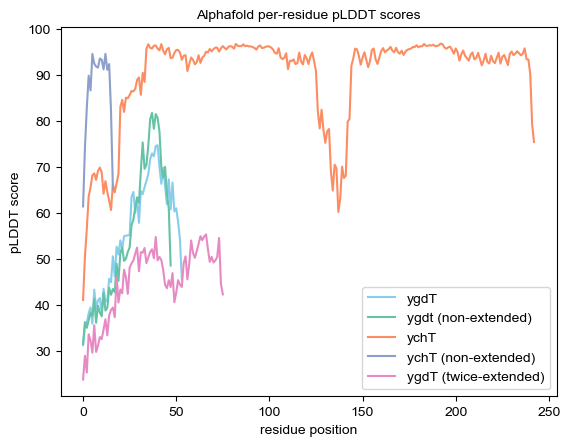

In [31]:
ygdt_2_model = 'model_3_multimer_v2_pred_3' # The name of the best Alphafold model. Score is 0.0611548995077531.

with open(f'{ALPHAFOLD_DATA_DIR}/ygdt_2/result_{ygdt_2_model}.pkl', 'rb') as f_2: 
    ygdt_2_model_info = pickle.load(f_2)

fig, ax = plt.subplots(1, figsize=(10, 3))

ax.plot(np.arange(len(ygdt_1_model_info['plddt'])), ygdt_1_model_info['plddt'], c='skyblue')
ax.plot(np.arange(len(ygdt_0_model_info['plddt'])), ygdt_0_model_info['plddt'])
ax.plot(np.arange(len(ycht_1_model_info['plddt'])), ycht_1_model_info['plddt'])
ax.plot(np.arange(len(ycht_0_model_info['plddt'])), ycht_0_model_info['plddt'])

ax.plot(np.arange(len(ygdt_2_model_info['plddt'])), ygdt_2_model_info['plddt'])

ax.set_ylabel('pLDDT score')
ax.set_xlabel('residue position')
ax.legend(['ygdT', 'ygdt (non-extended)', 'ychT', 'ychT (non-extended)', 'ygdT (twice-extended)'])
ax.set_title('Alphafold per-residue pLDDT scores')
plt.show()